# GAN - TensorFlow using MNIST

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [2]:
# Download MNIST dataset in numpy array format
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape it into 4-dim'l tensor and convert the type for `int` into `float`
train_images = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
test_images = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')

data_images = np.concatenate((train_images, test_images), axis=0)

# Set the pixel values from -1 to 1
data_images = (data_images/255.0) * 2 - 1

# Shuffle and seperate into batches
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_images).shuffle(data_images.shape[0]).batch(BATCH_SIZE)

2023-08-28 11:05:47.717572: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-28 11:05:47.720150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Deep Convolutional GANs

### Architecture guidelines for stable Deep Convolutional GANs

- Replace any pooling layers with `strided convolutions` (discriminator) and `fractional-strided convolutions` (generator).
- Use `BatchNormaliziation` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `ReLU` activation in `generator` for all layers except for the output, which uses Tanh.
- Use `LeakyReLU` activation in the `discriminator` for all layers.

In [3]:
## Hyperparameters
latent_dim = 50

EPOCHS = 70
LR = 2e-4
BETA1 = 0.5 # for Adam optimizer


### Generator

In [4]:
def create_generator(input_size=latent_dim):
    input_tensor = Input(shape=(input_size))

    x = Dense(150, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Dense(300, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Dense(500, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Dense(28*28, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = tanh(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [5]:
g_model = create_generator()
g_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               7650      
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               45300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 300)               0     

### Discriminator

In [6]:
def create_discriminator(input_shape=(28*28,)):

    input_tensor = Input(shape=input_shape)

    x = Dense(500, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Dense(250, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Dense(100, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Dense(50, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Dense(1, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = sigmoid(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model



In [7]:
d_model = create_discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
_________________________________________________________________
tf.nn.leaky_relu (TFOpLambda (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
batch_normalization_5 (Batch (None, 250)               1000      
_________________________________________________________________
tf.nn.leaky_relu_1 (TFOpLamb (None, 250)               0   

### GAN model

In [8]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, noise_size=latent_dim):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.noise_size = noise_size

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def create_gen_input(self, batch_size, seed=None):
        noise = tf.random.normal([batch_size, self.noise_size], seed=seed)
        return noise

    def train_step(self, real_img):

        criterion = BinaryCrossentropy()
        batch_size = tf.shape(real_img)[0]

        # Train Discriminator with fixed generator.
        with tf.GradientTape() as d_tape:
            self.discriminator.trainable = True
            self.generator.trainable = False
            d_tape.watch(self.discriminator.trainable_variables)

            # Real images have label 1 for the discriminator.
            real_label = tf.ones((batch_size, 1))

            # Create fake images
            noise = self.create_gen_input(batch_size=batch_size)
            fake_img = self.generator(noise)

            # Fake images have label 0 for the discriminator.
            fake_label = tf.zeros((batch_size, 1))

            # Compute discriminator output and its loss
            imgs   = tf.concat([real_img, fake_img], axis=0)
            labels = tf.concat([real_label, fake_label], axis=0)
            d_output = self.discriminator(imgs)
            d_loss = criterion(labels, d_output)

        # Compute gradients
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator with fixed discriminator.
        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False
            self.generator.trainable = True
            g_tape.watch(self.generator.trainable_variables)

            # Train generator using fake batch images. Fake images have label 1 for generators.
            noise = self.create_gen_input(batch_size=2*batch_size)
            fake_img = self.generator(noise)
            real_label = tf.ones((2*batch_size, 1))
            d_fake_output = self.discriminator(fake_img)
            g_loss = criterion(real_label, d_fake_output)

        # Compute gradients
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)

        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [9]:
gan = GAN(generator=g_model, discriminator=d_model)

gan.compile(d_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999),
            g_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999)
            )

history = gan.fit(train_dataset, epochs=EPOCHS)

Epoch 1/70
547/547 [==============================] - 26s 10ms/step - d_loss: 0.4159 - g_loss: 2.5315
Epoch 2/70
547/547 [==============================] - 6s 11ms/step - d_loss: 0.4299 - g_loss: 1.7768
Epoch 3/70
547/547 [==============================] - 5s 10ms/step - d_loss: 0.4062 - g_loss: 1.7774
Epoch 4/70
547/547 [==============================] - 6s 11ms/step - d_loss: 0.3760 - g_loss: 1.9389
Epoch 5/70
547/547 [==============================] - 6s 10ms/step - d_loss: 0.4172 - g_loss: 1.7396
Epoch 6/70
547/547 [==============================] - 6s 10ms/step - d_loss: 0.4335 - g_loss: 1.6795
Epoch 7/70
547/547 [==============================] - 5s 10ms/step - d_loss: 0.4383 - g_loss: 1.6572
Epoch 8/70
547/547 [==============================] - 6s 10ms/step - d_loss: 0.4557 - g_loss: 1.5840
Epoch 9/70
547/547 [==============================] - 7s 12ms/step - d_loss: 0.4735 - g_loss: 1.5390
Epoch 10/70
547/547 [==============================] - 6s 10ms/step - d_loss: 0.4785 - g_l

In [10]:
history.history.keys()

dict_keys(['d_loss', 'g_loss'])

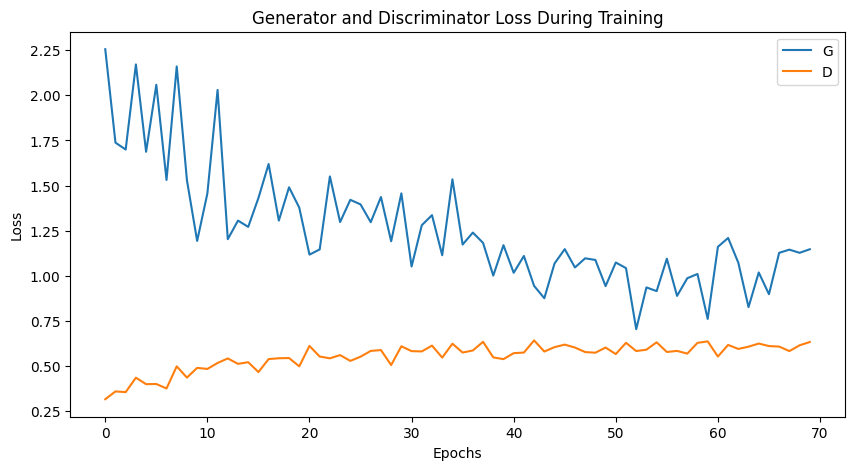

In [11]:
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('tensorflow_train_loss_plot.png')
plt.show()

In [12]:
# from google.colab import files

# files.download('tensorflow_train_loss_plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Save trained models

g_model.save_weights('saved_models/generator')
d_model.save_weights('saved_models/discriminator')

In [19]:
from google.colab import files

files.download('saved_models/checkpoint')
files.download('saved_models/generator.data-00000-of-00001')
files.download('saved_models/generator.index')
files.download('saved_models/discriminator.data-00000-of-00001')
files.download('saved_models/discriminator.index')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Load trained models

g_model.load_weights('saved_models/generator')
d_model.load_weights('saved_models/discriminator')

## Test

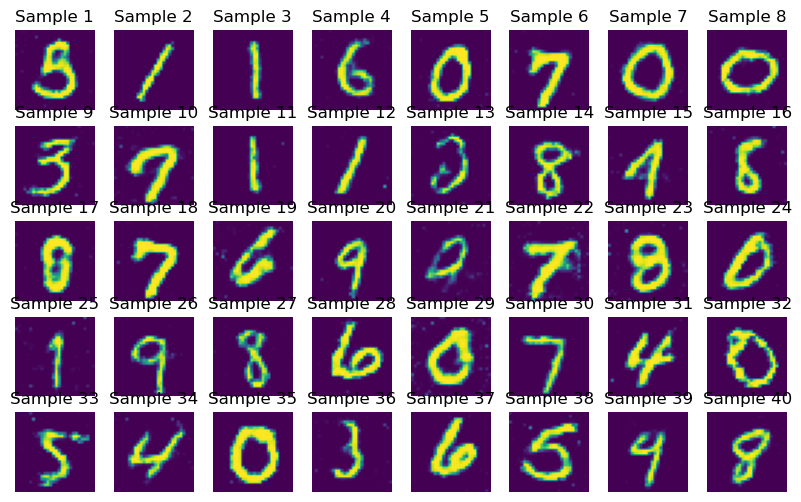

In [15]:
noise = tf.random.normal([40, latent_dim], seed=128)
generated_images = np.array(g_model(noise)).reshape(40,28,28)
generated_images = (generated_images + 1)/2 # convert the values from [-1,1] to [0,1] for plots

plt.rcParams['figure.figsize'] = (10.0, 6.0)

rows = 5
columns = 8

for i in range(40) :
    image_index = i+1      # image index
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot
    plt.title(title)   # title
    plt.axis('off')
    plt.xticks([])  # x = None
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])
plt.show()
